# Data analysis and feature extraction with Python
https://www.kaggle.com/pmarcelino/data-analysis-and-feature-extraction-with-python

Imports

In [8]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Put this when it's called
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

Functions

In [9]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [10]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [11]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

1. The lean data set


the lean startup approach relies on a Build-Measure-Learn process. This process emphasizes rapid iteration as a critical ingredient to product development. It goes through the following phases:

    Build. Figure out the problem that needs to be solved, generate ideas about how to solve it, and select the best one. Turn your best idea into a Minimum Viable Product (MVP).
    Measure. Test your product. Go to your customers and measure their reactions and behaviors against your product.
    Learn. Analyse the data you collected when testing the product with your customers. Draw conclusions from the experiment and decide what to do next. In other words, this is a validated learning process that quickly builds, tests, and rebuilds products, according to users' feedback. This reduces your market risks by failing fast and cheap, to get you closer and closer to what the market really needs.

This kernel does something similar. We will try to fail fast and cheap by quickly building a working end-to-end pipeline (Build). Then, we will instrument the system to evaluate its performance (Measure). Finally, we will make incremental changes to improve the system's performance (Learn). Note that this practical methodology was adapted from Goodfellow et al. (2016), a book you can access for free here.

Initially, we will not invest much time with exploratory data analysis. We will just do the minimum viable effort to implement a reasonable model. This model will be our 'Minimum Viable Model'. Later, we will try to beat this model by enriching our data.

Pop quiz: was the Titanic a MVP?

1.1. Doing the pitch


Startups use pitches to sell their idea. Accordingly, their pitch should be clear and concise, answering questions such as 'what do you do?', 'what do you want?', and 'who's on your team?'. The pitch is important because investors are more willing to invest when they understand what you're doing.

Let's return the first rows of our data set to get a clear and concise picture of what is there and what we can do with it.


In [18]:
# Import data
df = pd.read_csv('C:\\Users\\Masoumeh\\Desktop\\Data analysis and feature extraction with Python\\train.csv')
df_raw = df.copy()  # Save original data set, just in case.

In [19]:
# Overview
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Definitions and quick thoughts:

    PassengerId. Unique identification of the passenger. It shouldn't be necessary for the machine learning model.
    Survived. Survival (0 = No, 1 = Yes). Binary variable that will be our target variable.
    Pclass. Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd). Ready to go.
    Name. Name of the passenger. We need to parse before using it.
    Sex. Sex. Categorical variable that should be encoded.
    Age. Age in years. Ready to go.
    SibSp. # of siblings / spouses aboard the Titanic. Ready to go.
    Parch. # of parents / children aboard the Titanic. Ready to go.
    Ticket. Ticket number. Big mess. We need to understand its structure first.
    Fare. Passenger fare. Ready to go.
    Cabin. Cabin number. It needs to be parsed.
    Embarked. Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton). Categorical feature that should be encoded.

The main conclusion is that we already have a set of features that we can easily use in our machine learning model. Other features, like 'Name', 'Ticket', and 'Fare', require an additional effort before we can integrate them.



1.2. Showing the numbers



Numbers are crucial to set goals, to make sound business decisions, and to obtain money from investors. With numbers you can project the future of your startup, so that everyone can understand which are the expectations around your idea.

In the same way, we will generate the descriptive statistics to get the basic quantitative information about the features of our data set.


In [20]:
# Descriptive statistics
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are three aspects that usually catch my attention when I analyse descriptive statistics:

    Min and max values. This can give us an idea about the range of values and is helpful to detect outliers. In our case, all the min and max values seem reasonable and in a reasonable range of values. The only exception could eventually be the max value of 'Fare', but for now we will leave it as it is.
    Mean and standard deviation. The mean shows us the central tendency of the distribution, while the standard deviation quantifies its amount of variation. For example, a low standard deviation suggests that data points tend to be close to the mean. Giving a quick look to our values, there's nothing that looks like obviously wrong.
    Count. This is important to give us a first perception about the volume of missing data. Here, we can see that some 'Age' data is missing.

Since there's nothing shocking about the variables, let's proceed to the next step: missing data.


1.3. Filling the gaps



One of my favourite definitions of startup belongs to Eric Ries: 'a startup is a human institution designed to create a new product or service under conditions of extreme uncertainty'.

The word 'uncertainty' is key in this definition and it's also key in missing data. Missing data occurs when no data value on one or more variables is available. Consequently, it reduces the size of the data set and is a possible source of bias, since some non-random mechanism can be generating the missing data. As a result, missing data introduces uncertainty in our analysis.

There are several strategies to deal with missing data. Some of the most common are:

    Use only valid data, deleting the cases where data is missing.
    Impute data using values from similar cases or using the mean value.
    Impute data using model-based methods, in which models are defined to predict the missing values.

Until today, I've never found a 'one size fits all' solution. I have some dogmas (e.g. I usually exclude variables with more than 25% of missing data), but what usually guides my analysis is intuition, critical thinking and need (sometimes we need to leave our dogmas at the door, if we want to generate some results).

My practical advice to handle missing data is to learn a different set of tools. Play with them according to your needs, test them and you should be fine. A good introduction to the subject can be found in Hair et al. (2013). This book has a practical summary about missing data and provides a framework that you can apply in almost all situations. Also, I wrote a technical paper comparing different imputation techniques, which I can share with you if you want.

Now that we can see the tip of the iceberg, let's dive into the subject.
    

In [21]:
# Analyse missing data
draw_missing_data_table(df)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


First thoughts:

    'Cabin' has too many missing values (>25%). Dogma! We need to delete this variable right away.
    'Age' can be imputed. For now, I'll associate a value that allows me to know that I'm imputing data. Later, I'll revise this strategy.
    Due to the low percentage of missing values, I'll delete the observations where we don't know 'Embarked'.

In [22]:
# Drop Cabin
df.drop('Cabin', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [23]:
# Fill missing values in Age with a specific value
value = 1000
df['Age'].fillna(1000, inplace=True)
df['Age'].max()

1000.0

In [24]:
# Delete observations without Embarked
df.drop(df[pd.isnull(df['Embarked'])].index, inplace=True)  # Get index of points where Embarked is null
df[pd.isnull(df['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


1.4. Minimum viable model


The 'Minimum Viable Product' (MVP) is a key concept for any lean startup. Once the problem to solve is figured out, the focus of the startup should be in the development of a solution, the MVP, as fast as they can. Thanks to the MVP, it is possible to begin the learning process and improve the solution towards users needs.

Goodfellow et al. (2016) proposes an analogous approach for the application of machine learning models. As the authors point out, the successful application of machine learning techniques goes beyond the knowledge of algorithms and their principles. To successfully apply machine learning techniques, we need to start with a simple model that we can master and understand. Only then we should move to more complex algorithms.

The authors propose a practical four-steps methodology:

    Select a performance metric and a target value for this metric. This metric will guide your work and allow you to know how well you're performing. In our case, our performance metric will be 'accuracy' because it is the one defined by Kaggle.
    Quickly set up a working end-to-end pipeline. This should allow you to estimate the selected performance metric.
    Monitor the system to understand its behaviour, in particular to understand whether its poor performance is related to underfitting, overfitting or defects.
    Improve the system by iteration. Here we can apply feature engineering, tune hyperparameters or even change the algorithm, according to the outputs of our monitoring system.

We will follow this methodology. Accordingly, our aim will be to get an initial model that we can use as a first baseline approach. This model will be our 'Minimum Viable Model' (MVM). Note that right now it doesn't matter much how well the model performs. We just need a starting point. All in all, we're entrepreneurs. Worst case scenario, we name this model as 'beta version' :P

Ok, let's prepare the data for the MVM launching, fit a logistic regression to it, and analyse the performance of the model through learning and validation curves.


1.4.1. Preparing the data


In [25]:
# Data types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

   We don't need 'PassengerId' for prediction purposes, so we will exclude it.
    'Sex', 'Embarked', and 'Pclass' should be categorical. I'll not consider 'Survived' as categorical because it's the output variable.
    We need to parse 'Name' and 'Ticket'. For now, I'll ignore these features.
    'SibSp' could be grouped with 'Parch' to create a 'Family' feature. For now, I'll just identify if the passenger is travelling alone or with family.


In [26]:
# Drop PassengerId
df.drop('PassengerId', axis=1, inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [27]:
# Define categorical variables
df['Sex'] = pd.Categorical(df['Sex'])
df['Embarked'] = pd.Categorical(df['Embarked'])

In [28]:
# Create Family feature
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [29]:
# Drop SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0


In [30]:
# Drop Name and Ticket
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


1.4.2. Launching the model


Ready... Set... Go!


In [31]:
# Transform categorical variables into dummy variables
df = pd.get_dummies(df, drop_first=True)  # To avoid dummy trap
df.head()

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,1,0,1
1,1,1,38.0,71.2833,1,0,0,0
2,1,3,26.0,7.9250,0,0,0,1
3,1,1,35.0,53.1000,1,0,0,1
4,0,3,35.0,8.0500,0,1,0,1


Extra: What is the 'dummy variable trap'?

In [32]:
# Create data set to train data imputation methods
X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [33]:
# Debug
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
      Pclass     Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S
121       3  1000.0    8.0500           0         1           0           1
687       3    19.0   10.1708           0         1           0           1
790       3  1000.0    7.7500           0         1           1           0
837       3  1000.0    8.0500           0         1           0           1
659       1    58.0  113.2750           2         1           0           0
Outputs: 
 121    0
687    0
790    0
837    0
659    0
Name: Survived, dtype: int64


In [34]:
# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [35]:
# Model performance
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

CV accuracy: 0.783 +/- 0.035


C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

1.4.3. Assessing model performance

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

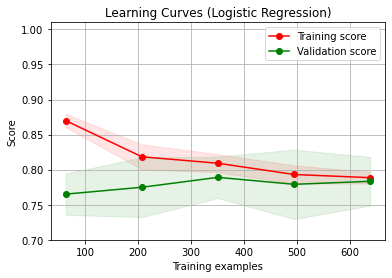

In [36]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

Learning curves in a nutshell:

    Learning curves allow us to diagnose if the is overfitting or underfitting.
    When the model overfits, it means that it performs well on the training set, but not not on the validation set. Accordingly, the model is not able to generalize to unseen data. If the model is overfitting, the learning curve will present a gap between the training and validation scores. Two common solutions for overfitting are reducing the complexity of the model and/or collect more data.
    On the other hand, underfitting means that the model is not able to perform well in either training or validations sets. In those cases, the learning curves will converge to a low score value. When the model underfits, gathering more data is not helpful because the model is already not being able to learn the training data. Therefore, the best approaches for these cases are to improve the model (e.g., tuning the hyperparameters) or to improve the quality of the data (e.g., collecting a different set of features).

Discussion of our results:

    The model doesn't overfit. As we can see, the curves converge and no gap between the training and the validation score exists in the last points of the curve.
    The model underfits. Our final score is about 0.786. Although our model does better predictions than a flip-a-coin strategy, it is still far from being an 'intelligent' model. For now, it's just an 'artificial' model.

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=C, param_range=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], groups=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

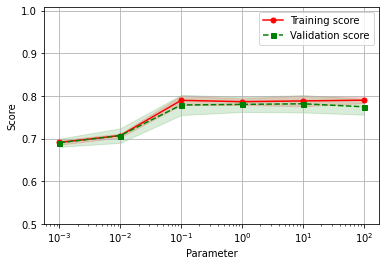

In [37]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train, y=y_train, param_name=param_name,
                      ylim=(0.5, 1.01), param_range=param_range);

Validation curves in a nutshell:

    Validation curves are a tool that we can use to improve the performance of our model. It counts as a way of tuning our hyperparameters.
    They are different from the learning curves. Here, the goal is to see how the model parameter impacts the training and validation scores. This allow us to choose a different value for the parameter, to improve the model.
    Once again, if there is a gap between the training and the validation score, the model is probably overfitting. In contrast, if there is no gap but the score value is low, we can say that the model underfits.

Discussion of our results:

    The figure shows that there is no huge difference in model's performance as far as we choose a C value of 10−1

or higher. Note that in a logistic regression, C is the only model parameter that we can change (see scikit-learn documentation). 

2. The chubby data set


At this point, our model:

    Can achieve a 0.786 +/- 0.026 accuracy.
    Is based on a logistic regression.
    Uses 'Pclass', 'Age', 'Fare', 'FamilySize', 'Sex', and 'Embarked as inputs; and 'Survived' as output.

Moreover, concerning the practical methodology that we mentioned before, we can say that:

    The choice of the performance metric is a closed topic because we're following Kaggle's specifications.
    Our current model can work as a baseline model and resulted from a working end-to-end pipeline.
    The learning and validation curves allow us to monitor system's performance.

As a consequence, only the fourth and last step of the practical methodology is missing: to improve the model by iteration. This can be done by:

    Improving the way how we handled 'Age' missing data. In our lean approach we decided to replace missing data by a unique value, but now we can go deeper and search for a better imputation strategy.
    Exploring data to understand which features can have impact in the model and how they can be manipulated to boost that impact.
    Building new features that can increase the predictive power of our model.

This will lead us to a heavy data analysis process, which aims to improve model's performance just by the data quality side. In other words, we will not change our learning algorithm neither we will try to improve its parameters. We will only try to improve the performance of our model by enriching our data.

That said, let's say goodbye to the lean approach and welcome the chubby approach!


In [38]:
# Restart data set
df = df_raw.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
# Family size feature
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [40]:
# Drop SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [41]:
# Drop irrelevant features
df.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,male,22.0,7.2500,S,1
1,2,1,1,female,38.0,71.2833,C,1
2,3,1,3,female,26.0,7.9250,S,0
3,4,1,1,female,35.0,53.1000,S,1
4,5,0,3,male,35.0,8.0500,S,0


2.1. Imputation of 'Age' missing data


Our initial approach to estimate 'Age' missing values was to fill with a placeholder value (1000). This allowed us to quickly get a complete data set, in which was easy to identify imputed values. Since our goal was to have a working end-to-end pipeline as fast as possible, this approach was ok. However, it has several limitations. For example, we are using unrealistic replacement values, which are out of range and distort data distribution. Accordingly, now that we are improving the model, it makes sense to develop a different imputation method.

One way to improve our imputation method is to estimate the missing values based on known relationships. In our case, we can do this by using the information in the variable 'Name'. Looking to 'Name' values, we can see person's name and title. Person's title is a relevant information to estimate ages. To give an example, we know that a person with the title 'Master' is someone under 13 years old, since 'a boy can be addressed as master only until age 12'. Therefore, employing the information in 'Name' we can improve our imputation method.

The steps to implement this new imputation method are:

    Extract titles from 'Name'.
    Plot a figure with both features and confirm that there is a connection between titles and age.
    For each title, get people's average age and use it to fill missing values.

Let's see how this work, before you start with sinking feelings.


In [42]:
# Inspect names
df_raw['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

The rule seems to be: 'last name' + ',' + 'title' + 'other names'

In [43]:
# Extract titles from name
df['Title']=0
for i in df:
    df['Title']=df_raw['Name'].str.extract('([A-Za-z]+)\.', expand=False)  # Use REGEX to define a search pattern
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,1,0,3,male,22.0,7.2500,S,1,Mr
1,2,1,1,female,38.0,71.2833,C,1,Mrs
2,3,1,3,female,26.0,7.9250,S,0,Miss
3,4,1,1,female,35.0,53.1000,S,1,Mrs
4,5,0,3,male,35.0,8.0500,S,0,Mr


In [44]:
# Unique titles
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

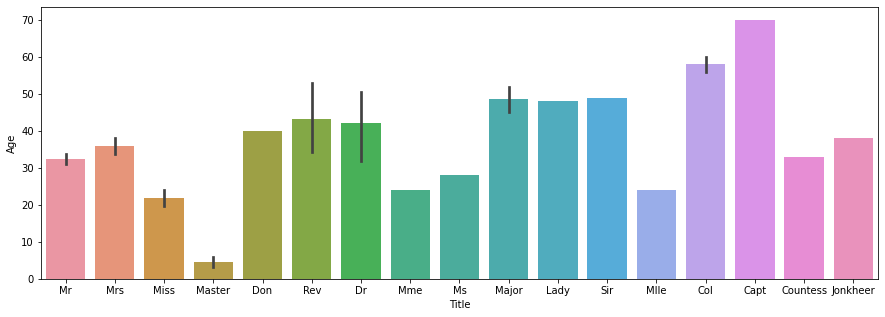

In [45]:
# Plot bar plot (titles, age and sex)
plt.figure(figsize=(15,5))
sns.barplot(x=df['Title'], y=df_raw['Age']);

    Bar plot gives us an estimate of central tendency for a numeric variable (height of each rectangle) and an indication of the uncertainty around that estimate (error bars in black).
    Apart from Rev and Dr, which have a larger error bar, the mean value seems to accurately represent the data of all the other features. This validates our approach.
    Here you can find a short and sweet intro to error bars interpretation.

In [46]:
# Means per title
df_raw['Title'] = df['Title']  # To simplify data handling
means = df_raw.groupby('Title')['Age'].mean()
means.head()

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          42.0
Name: Age, dtype: float64

In [47]:
# Transform means into a dictionary for future mapping
map_means = means.to_dict()
map_means

{'Capt': 70.0,
 'Col': 58.0,
 'Countess': 33.0,
 'Don': 40.0,
 'Dr': 42.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.574166666666667,
 'Miss': 21.773972602739725,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Ms': 28.0,
 'Rev': 43.166666666666664,
 'Sir': 49.0}

In [48]:
# Impute ages based on titles
idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age,'Age'].loc[idx_nan_age] = df['Title'].loc[idx_nan_age].map(map_means)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,1,0,3,male,22.0,7.2500,S,1,Mr
1,2,1,1,female,38.0,71.2833,C,1,Mrs
2,3,1,3,female,26.0,7.9250,S,0,Miss
3,4,1,1,female,35.0,53.1000,S,1,Mrs
4,5,0,3,male,35.0,8.0500,S,0,Mr


In [49]:
# Identify imputed data
df['Imputed'] = 0
df.at[idx_nan_age.values, 'Imputed'] = 1
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Imputed
0,1,0,3,male,22.0,7.2500,S,1,Mr,0
1,2,1,1,female,38.0,71.2833,C,1,Mrs,0
2,3,1,3,female,26.0,7.9250,S,0,Miss,0
3,4,1,1,female,35.0,53.1000,S,1,Mrs,0
4,5,0,3,male,35.0,8.0500,S,0,Mr,0


2.2. Exploratory data analysis


Exploratory data analysis is often mentioned as one of the most important steps in the data analysis process. However, it's fairly easy to fall into a 'data diving' trap (especially if you're solving problems about sunken ships) and get lost into the process. When that happens, your analysis can end up like this.

We can avoid this by following a hypothesis driven approach. The hypothesis driven approach consists in establishing hypothesis about the variables behaviour and their relationships, early in the process, to then focus on using data to prove (or disprove) those hypothesis. This makes our analysis very objective because we will be collecting just enough data to test specific hypothesis. As a result, we:

    Increase speed. Since we will limit our analysis to some hypothesis and move forward.
    Reduce effort. The amount of data and the number of tests will be only what is needed to verify your hypothesis.
    Reduce risk. If you're right you succeed fast, if you're wrong you fail fast.

Here you can find one of my favourite PowerPoint presentations about the benefits and procedures of a hypothesis driven approach in problem solving. Please note that, particularly when you really need to learn about the data set, it makes sense to put the diving cylinder and go dive into the depths of data analysis. However, if at the outset you can generate an educated guess of what the answer of your problem is, I think that you should test your hypothesis and learn from it as fast as you can.

Ok, now that I convinced you that the hypothesis driven approach is the last coke in the desert, let me show you how to apply it. Cases like the one we have are easy targets for the hypothesis driven approach because we don't have many variables, so we can more or less guess their impact. Accordingly, we will start by listing each of the variables and generate hypothesis about their relationship with the target variable ('Survived'). Then, we will test those hypothesis through a set of exploratory data analysis tools. As a result, we'll end up with a comprehensive view about the variables that should belong to our prediction model.

Let's get started:

    PassengerId. This is just an unique identification of each passenger. It's not expected to be relevant to our analysis.
    Survived. Target variable. To sink or not to sink is the question of this exercise.
    Pclass. This is the ticket class. According to Karl Marx, this should affect our target variable. First class should have a higher survival rate.
    Name. Names are a form of social tagging, especially when accompanied by a title. As a consequence, it can lead to different forms of treatment. Let's keep an eye on this.
    Sex. Always important.
    Age. It should make a difference. For example, children are usually evacuated first in a disaster, so that we can think about a solution in silence... Joking, the true reason why 'Age' matters is this one.
    SibSp. Number of siblings/spouses aboard the Titanic. I'd say that it's easier to survive if you're with your family than if you're travelling alone. Teamwork!
    Parch. Number of parents/children aboard the Titanic. It should play with 'SibSp'.
    Ticket. This is the ticket number. Unless it has some information about places, it shouldn't be important for prediction purposes.
    Fare. Same logic as 'Pclass'.
    Cabin. The cabin number can indicate where people were during the disaster. It wouldn't be surprising if it had some influence in survival chances, but this variable was excluded due to the high percentage of missing values.
    Embarked. When the sun rises, it rises for everyone. It's not expectable that people coming from Cherbourg are more unlucky than people coming from Southampton. Unless there is some second order effect, like refusing to run away to keep your honor as a man, I would say that this variable is not important.

Now, step by step, let's perform our analysis.

2.2.1. Pclass


Our hypothesis is that the higher the class, the higher the chances of survival. This means that a person travelling in the first class has a higher chance of survival than a person traveling on the second or third class.

To visualize if there is a relationship between 'Pclass' and 'Survival', let's do a bar plot.


C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


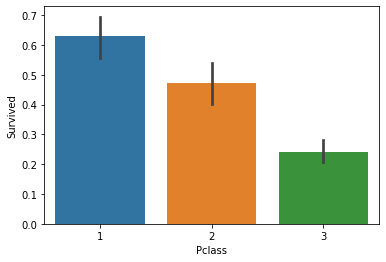

In [50]:
# Plot
sns.barplot(df['Pclass'],df['Survived']);

As we can see, about 60% of the people travelling in the first class survived. In contrast, only approximately 25% of the people travelling in the third class survived. Accordingly, this plot suggests that the class in which people travel affects the chances of survival.

2.2.2. Name/Title

Our assumption is that people's title influences how they are treated. In our case, we have several titles, but only some of them are shared by a significant number of people. Accordingly, it would be interesting if we could group some of the titles and simplify our analysis.

Let's analyse the title and see if we can can find a sensible way to group them. Then, we test our new groups and, if it works in an acceptable way, we keep it. For now, optimization will not be a goal. The focus is on getting something that can improve our current situation.


In [51]:
# Count how many people have each of the titles
df.groupby(['Title'])['PassengerId'].count()

Title
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: PassengerId, dtype: int64

From the results above we can see that:

    Titles like 'Master', 'Miss', 'Mr', and 'Mrs', appear several times. Accordingly, we will not group them.
    Regarding Mme and Mlle, we can see here that they correspond to the categories Mrs and Miss, respectively. As a consequence, we will assign them to those titles.
    Finally, we will group all the other titles in a new title named 'Other'. Then, we will define 'Title' as a categorical feature and plot it to see how it looks like. If it looks ok, we will proceed with this new categorization.

In [52]:
# Map of aggregated titles:
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

In [53]:
# Group titles
df['Title'] = df['Title'].map(titles_dict)
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [54]:
# Transform into categorical
df['Title'] = pd.Categorical(df['Title'])
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Sex              object
Age             float64
Fare            float64
Embarked         object
FamilySize        int64
Title          category
Imputed           int64
dtype: object

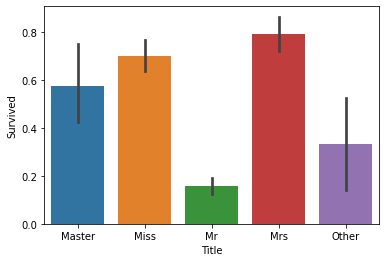

In [55]:
# Plot
sns.barplot(x='Title', y='Survived', data=df);

As we already know, the bar plot shows us an estimate of the mean value (height of each rectangle) and an indication of the uncertainty around that central tendency (error bars).

Our results suggest that:

    People with the title 'Mr' survived less than people with any other title.
    Titles with a survival rate higher than 50% are those that correspond to female (Miss or Mrs) or children (Master) titles.
    Our new category, 'Other', should be more discretized. As we can see by the error bar (black line), there is a significant uncertainty around the mean value. Probably, one of the problems is that we are mixing male and female titles in the 'Other' category. We should proceed with a more detailed analysis to sort this out. Also, the category 'Master' seems to have a similar problem. For now, we will not make any changes, but we will keep these two situations in our mind for future improvement of our data set.

2.2.3. Sex

Sex is one of the most discussed topics in Human history. There are several perspective about the topic, but I must confess that Freud's perspectives had a significant impact on me because they have shown me the subject in a new perspective. What's new about Freud is that he associated many 'normal' behaviours to sexual drives, almost to the point of making us question everything we do. In the end, Freud realized that not everything was about sex. As he said, 'sometimes a cigar is just a cigar' (Freud used to smoke cigars).

Preambles aside, what we really need to know is if sometimes a cigar is just a cigar or not. We already have some clues that, in Titanic, women had a higher survival rate. But, nothing better than a plot to see what's going on.


In [56]:
# Transform into categorical
df['Sex'] = pd.Categorical(df['Sex'])

C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


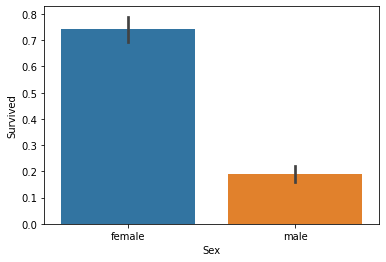

In [57]:
# Plot
sns.barplot(df['Sex'],df['Survived']);

Our hypothesis seems to be right. The world belongs to women, and so does the Titanic.

2.2.4. Age

'Age' is the next variable in the list. Our hypothesis is that children are more prone to survive, while people in its adult life may have a lower rate of survival. Personally, I don't have any special intuition about elders, since they are the most vulnerable. This can play for both sides: either people help elders because they are more vulnerable, or they they are not able to cope with the challenges posed by the wreck of a ship.

Let's call the usual suspect (bar plot) to help us understanding the situation.


C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


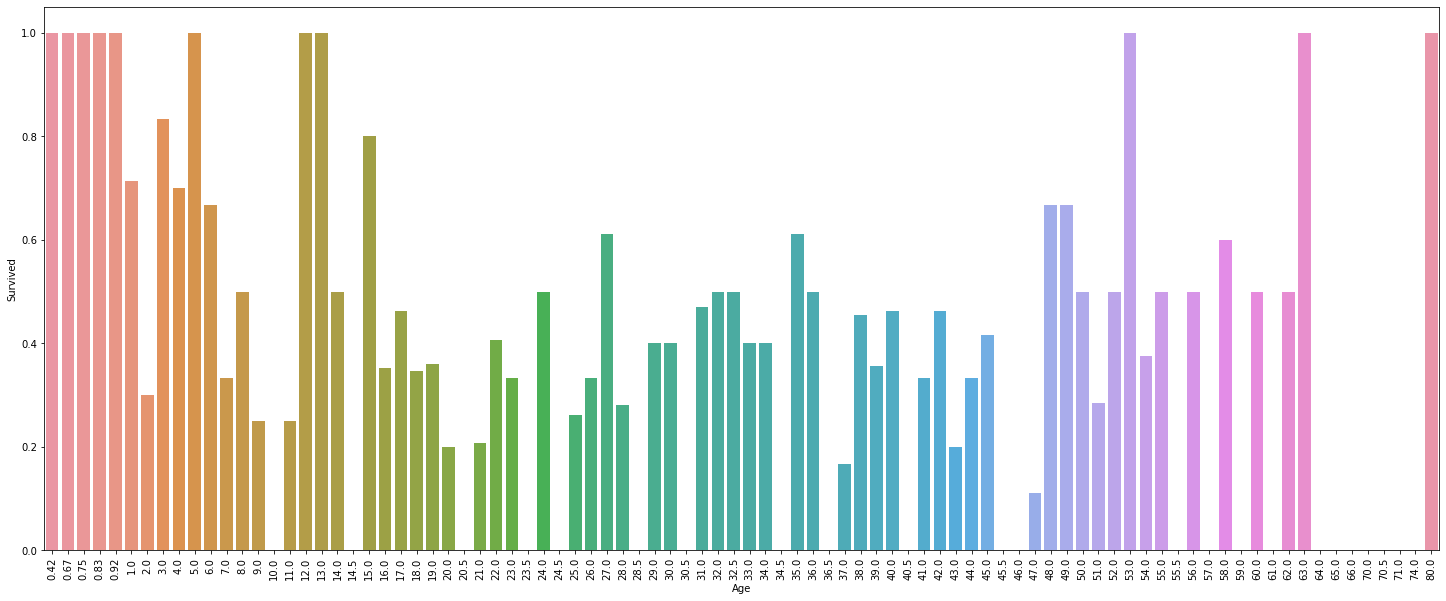

In [58]:
# Plot
plt.figure(figsize=(25,10))
sns.barplot(df['Age'],df['Survived'], ci=None)
plt.xticks(rotation=90);

With a little bit of creativity, we can say that the plot has three regions:

    One region that goes between age 0 and 15;
    One between age 15 and 48;
    A last one between age 48 and 80.

I know that this division is arguable, especially in what concerns the last two categories. However, the point is that this categories split fits into what we know about the way our society is organized: childrens, adults and elders. For now, let's proceed this way.


C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


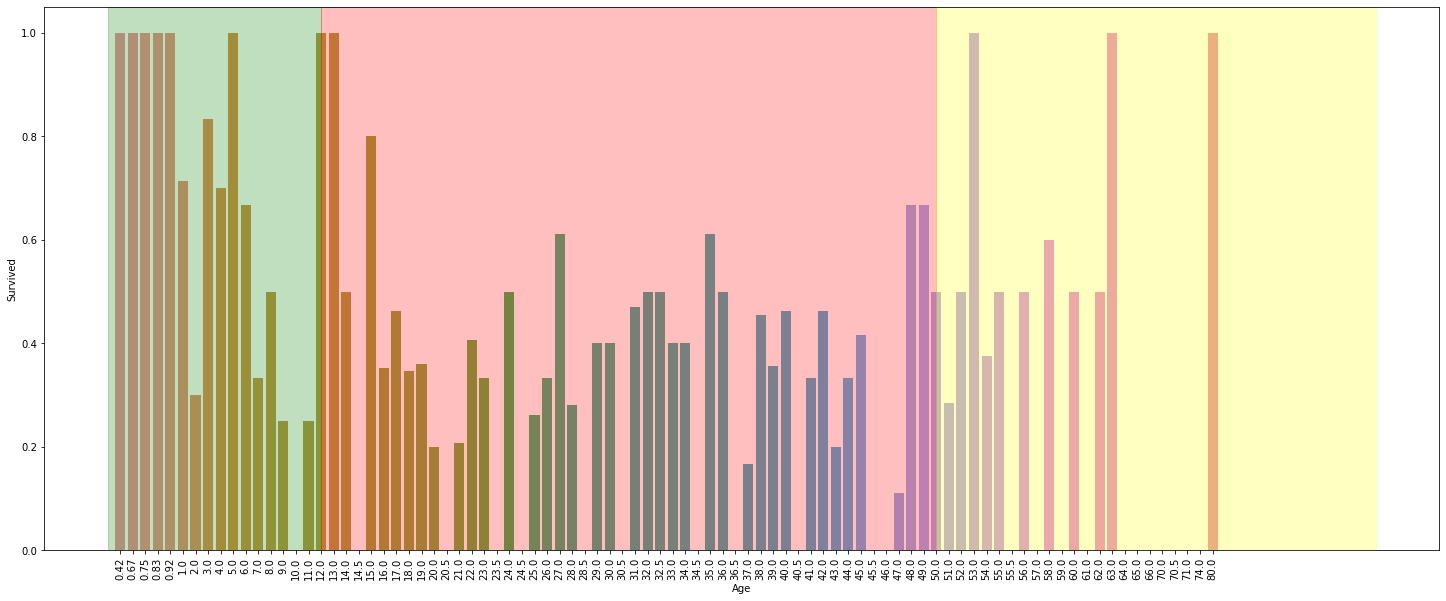

In [59]:
# Plot
'''
Probably, there is an easier way to do this plot. I had a problem using
plt.axvspan because the xmin and xmax values weren't
being plotted correctly. For example, I would define xmax = 12 and only 
the area between 0 and 7 would be filled. This was happening because my 
X-axis don't follow a regular (0, 1, ..., n) sequence. After some trial
and error, I noticed that xmin and xmax refer to the number of elements in
the X-axis coordinate that should be filled. Accordingly, I defined two 
variables, x_limit_1 and x_limit_2, that count the number of elements that
should be filled in each interval. Sounds confusing? To me too.
'''
limit_1 = 12
limit_2 = 50

x_limit_1 = np.size(df[df['Age'] < limit_1]['Age'].unique())
x_limit_2 = np.size(df[df['Age'] < limit_2]['Age'].unique())

plt.figure(figsize=(25,10))
sns.barplot(df['Age'],df['Survived'], ci=None)

plt.axvspan(-1, x_limit_1, alpha=0.25, color='green')
plt.axvspan(x_limit_1, x_limit_2, alpha=0.25, color='red')
plt.axvspan(x_limit_2, 100, alpha=0.25, color='yellow')

plt.xticks(rotation=90);

In [60]:
# Bin data
df['Age'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])
df['Age'].head()

0    Adult
1    Adult
2    Adult
3    Adult
4    Adult
Name: Age, dtype: category
Categories (3, object): ['Child' < 'Adult' < 'Elder']

C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


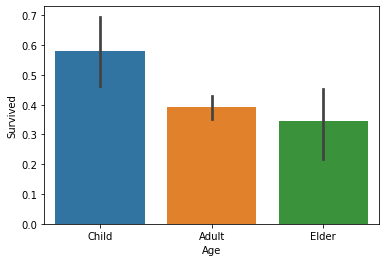

In [61]:
# Plot
sns.barplot(df['Age'], df['Survived']);

The plot shows that children have a higher survival rate. It also shows that, in terms of survival, there is not a significant difference between the categories 'Adult' and 'Elder'. For now, we will not make any change because there is a theoretical rationale behind this categorization. Nonetheless, it seems that it would be enough to just distinguish between children and adults.

2.2.5. FamilySize

Regarding family size, our hypothesis is that those who travel alone, have a lower survival rate. The idea is that people with family can collaborate and help each other escaping.

Let's see if that makes sense using our beautiful and only friend, the bar plot.


C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


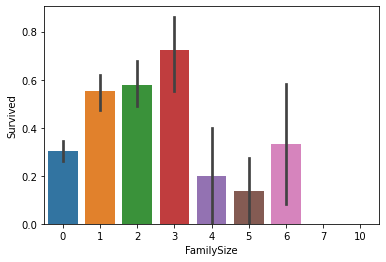

In [62]:
# Plot
sns.barplot(df['FamilySize'], df['Survived']);

As we can see, when 'FamilySize' is between 0 and 3, our hypothesis finds some support. People that are travelling alone have a lower survival rate than people who are travelling with one, two or three people more.

However, when FamilySize is between 4 and 10, things start to change. Despite the large variability of the results, the survival rate drops. This may suggest that our hypothesis should be revised when 'FamilySize' is higher than 3.

This variable seems to be more complex than expected. Accordingly, we will not make any transformation in this variable and we will leave it as a continuous variable to preserve all the information it has.

2.2.6. Fare

The same logic applied to 'Pclass' should work for 'Fare': higher fares, higher survival rate.

Since now we want to establish comparisons across different levels of a categorical variable, we will use a box plot instead of a bar plot.


C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


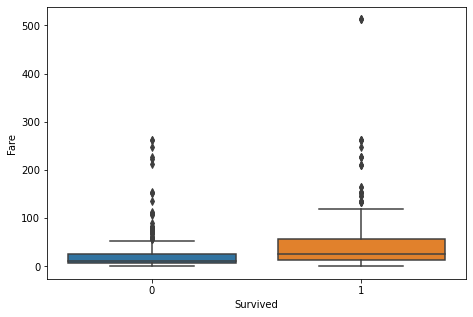

In [63]:
# Plot
plt.figure(figsize=(7.5,5))
sns.boxplot(df['Survived'], df['Fare']);

The plot suggests that those who survived paid a higher fare. Since we believe this variable is connected with 'Pclass', let's see how they work together.


C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


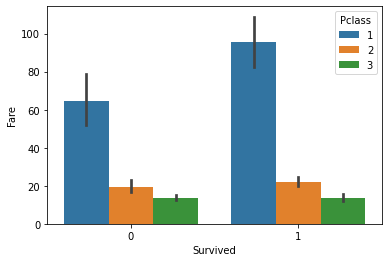

In [64]:
# Plot
sns.barplot(df['Survived'], df['Fare'], df['Pclass']);

Here we have an interesting result. It seems that 'Fare' doesn't make difference, in terms of survival, if you are travelling in second or third class. However, if you are travelling in first class, the higher the fare, the higher the chances of survival. Considering this, it would make sense to create interaction features between 'Fare' and 'Pclass'.


2.2.7. Embarked

The hypothesis regarding 'Embarked' is that it doesn't influence the chances of survival. It is hard to imagine a scenario in which people from Southampton, for instance, would such a competitive advantage, that it would make them more apt for survival than people from Queensland. Yes, in Darwin we believe.

A simple plot can enlighten us.


C:\Users\Masoumeh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


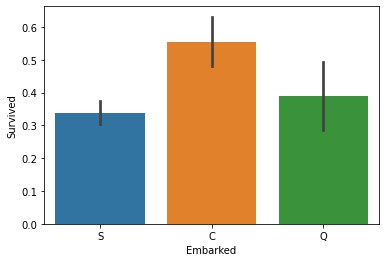

In [65]:
# Plot
sns.barplot(df['Embarked'], df['Survived']);

Ups... It seems that people embarking on C were selected by a superior entity to survive. This is strange and may be hidding some relationship that is not obvious with this plot (e.g. people embarking on C were mostly women).

Let's dive deeper.


In [66]:
# Compare with other variables
df.groupby(['Embarked']).mean()

,PassengerId,Survived,Pclass,Fare,FamilySize,Imputed
Embarked,,,,,,
C,445.357143,0.553571,1.886905,59.954144,0.750000,0.226190
Q,417.896104,0.389610,2.909091,13.276030,0.597403,0.636364
S,449.527950,0.336957,2.350932,27.079812,0.984472,0.139752


It seems that people embarking on C were paying more and travelling in a better class than people embarking on Q and S.


In [67]:
# Relationship with age
df.groupby(['Embarked','Age'])['PassengerId'].count()

Embarked  Age  
C         Child     11
          Adult    104
          Elder     15
Q         Child      4
          Adult     21
          Elder      3
S         Child     54
          Adult    455
          Elder     45
Name: PassengerId, dtype: int64

No significant differences can be found.

In [68]:
# Relationship with sex
df.groupby(['Embarked','Sex'])['PassengerId'].count()

Embarked  Sex   
C         female     73
          male       95
Q         female     36
          male       41
S         female    203
          male      441
Name: PassengerId, dtype: int64



No significant differences can be found.

Considering the results above, I feel tempted to say that the embarkment point doesn't influence the survival rate. What really seems to be influencing is the class where people were travelling and how much they were spending.

For now, I will not delete the variable because I feel that I'm a little bit biased and trying to force a conclusion. However, let's keep in mind that maybe 'Embarked' doesn't affect 'Survived'.
2.3. Feature extraction

In the book 'How Google Works', Eric Schmidt and Jonathan Rosenberg refer that Google's secret sauce is 'technical insight'. According to the authors, it is fundamental technical insight that allows companies to create great products, which provide real value to the customers. For example, PageRank gave an incredible competitive advantage to Google in relation to other search engines, by providing a far better way to rank search results on the web.

Feature extraction is our technological insight in machine learning. It addresses the problem of attaining the most informative and compact set of features, to improve the performance of machine learning models. Let's go step-by-step. First, we are talking about 'informative'. This means that we are looking for features that can characterize the behaviour of what we are trying to model. For instance, if we want to model the weather, features like temperature, humidity and wind are informative (they are related to the problem). By contrast, the result of a football game will not be an informative feature because it doesn't affect the weather.

Regarding 'compact', what we mean is that we want to exclude irrelevant features from our model. There are several reasons to exclude irrelevant features. In our case, I'd say that the most important is to reduce overfitting. Taking the weather example again: we know that football scores do not affect weather, but suppose that all rain instances in our training set happen to occur after a Benfica victory. Then, our model might learn that rain is related to Benfica's victories, which is not true. Such an incorrect generalization from an irrelevant feature of the training set would result in a machine learning model that fits a particular set of data, but fails to predict future observations reliably (overfitting).

These two main issues are addressed in the following sub-sections:

    Feature engineering, which is related to the generation of informative features;
    Feature selection, which regards the choice of a compact set of features.

2.3.1. Feature engineering

Feature engineering is the art of converting raw data into useful features. There are several feature engineering techniques that you can apply to be an artist. A comprehensive list of them is presented by Heaton (2016). We will use just two techniques:

    Box-Cox transformations (Box & Cox 1964);
    Polynomials generation through non-linear expansions.

Before the application of these techniques, we will just make some adjustments to the data, in order to prepare it for the modelling process.
Data preparation

In [69]:
# Overview
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Imputed
0,1,0,3,male,Adult,7.2500,S,1,Mr,0
1,2,1,1,female,Adult,71.2833,C,1,Mrs,0
2,3,1,3,female,Adult,7.9250,S,0,Miss,0
3,4,1,1,female,Adult,53.1000,S,1,Mrs,0
4,5,0,3,male,Adult,8.0500,S,0,Mr,0


In [70]:
# Drop feature
df.drop('PassengerId', axis=1, inplace=True)

In [71]:
# Check features type
df.dtypes

Survived         int64
Pclass           int64
Sex           category
Age           category
Fare           float64
Embarked        object
FamilySize       int64
Title         category
Imputed          int64
dtype: object

In [72]:
# Transform object into categorical
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
df.dtypes

Survived         int64
Pclass        category
Sex           category
Age           category
Fare           float64
Embarked      category
FamilySize       int64
Title         category
Imputed          int64
dtype: object

In [73]:
# Transform categorical features into dummy variables
df = pd.get_dummies(df, drop_first=1)  
df.head()

,Survived,Fare,FamilySize,Imputed,Pclass_2,Pclass_3,Sex_male,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,7.2500,1,0,0,1,1,1,0,0,1,0,1,0,0
1,1,71.2833,1,0,0,0,0,1,0,0,0,0,0,1,0
2,1,7.9250,0,0,0,1,0,1,0,0,1,1,0,0,0
3,1,53.1000,1,0,0,0,0,1,0,0,1,0,0,1,0
4,0,8.0500,0,0,0,1,1,1,0,0,1,0,1,0,0


In [74]:
# Get training and test sets
from sklearn.model_selection import train_test_split

X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)


Box-Cox transformations

Box-Cox transformations aim to normalize variables. These transformations are an alternative to the typical transformations, such as square root transformations, log transformations, and inverse transformations. The main advantage of Box-Cox transformations is that they optimally normalize the chosen variable. Thus, they avoid the need to randomly try different transformations and automatize the data transformation process.


In [75]:
# Apply Box-Cox transformation
from scipy.stats import boxcox

X_train_transformed = X_train.copy()
X_train_transformed['Fare'] = boxcox(X_train_transformed['Fare'] + 1)[0]
X_test_transformed = X_test.copy()
X_test_transformed['Fare'] = boxcox(X_test_transformed['Fare'] + 1)[0]


Polynomials

One standard way to enrich our set of features is to generate polynomials. Polynomial expansion creates interactions between features, as well as creates powers (e.g. square of a feature). This way we introduce a nonlinear dimension to our data set, which can improve the predictive power of our model.

We should scale our features when we have polynomial or interaction terms in our model. These terms tend to produce multicollinearity, which can make our estimates very sensitive to minor changes in the model. Scaling features to a range allow us to reduce multicollinearity and its problems.

To scale the features, we will transform the data so that it lies between a given minimum and maximum value. We will follow the common practice and say that our minimum value is zero, and our maximum value is one.


In [76]:
# Rescale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

In [77]:
# Get polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2).fit(X_train_transformed)
X_train_poly = poly.transform(X_train_transformed_scaled)
X_test_poly = poly.transform(X_test_transformed_scaled)

In [78]:
# Debug
print(poly.get_feature_names())

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x6 x13', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x7 x13', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x8 x13', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x9 x13', 'x10^2', 'x10 x11', '


2.3.2. Feature selection

The next step is to perform feature selection. Feature selection is about chosing the relevant information. It is good to add and generate features, but at some point we need to exclude irrelevant features. Otherwise, we will be penalizing the predictive power of our model. You can find a concise introduction to the feature selection subject in Guyon & Elisseeff (2003).

In this work, we will use a univariate statistics approach. This approach selects features based on univariate statistical tests between each feature and the target variable. The intuition is that features that are independent from the target variable, are irrelevant for classification.

We will use the chi-squared test for feature selection. This means that we have to choose the number of features that we want in the model. For example, if we want to have three features in our model, the method will select the three features with highest χ2

score.

Since we don't know the ideal number of features, we will test the method with all the possible number of features and choose the number of features with better performance.
Univariate statistics


In [79]:
# Select features using chi-squared test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Get score using original model
logreg = LogisticRegression(C=1)
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy (original): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
highest_score = np.mean(scores)

## Get score using models with feature selection
for i in range(1, X_train_poly.shape[1]+1, 1):
    # Select i features
    select = SelectKBest(score_func=chi2, k=i)
    select.fit(X_train_poly, y_train)
    X_train_poly_selected = select.transform(X_train_poly)

    # Model with i features selected
    logreg.fit(X_train_poly_selected, y_train)
    scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
    print('CV accuracy (number of features = %i): %.3f +/- %.3f' % (i, 
                                                                     np.mean(scores), 
                                                                     np.std(scores)))
    
    # Save results if best score
    if np.mean(scores) > highest_score:
        highest_score = np.mean(scores)
        std = np.std(scores)
        k_features_highest_score = i
    elif np.mean(scores) == highest_score:
        if np.std(scores) < std:
            highest_score = np.mean(scores)
            std = np.std(scores)
            k_features_highest_score = i
        
# Print the number of features
print('Number of features when highest score: %i' % k_features_highest_score)

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

CV accuracy (original): 0.825 +/- 0.031
CV accuracy (number of features = 1): 0.789 +/- 0.046
CV accuracy (number of features = 2): 0.789 +/- 0.046
CV accuracy (number of features = 3): 0.789 +/- 0.046
CV accuracy (number of features = 4): 0.789 +/- 0.046
CV accuracy (number of features = 5): 0.789 +/- 0.046
CV accuracy (number of features = 6): 0.789 +/- 0.046
CV accuracy (number of features = 7): 0.785 +/- 0.042
CV accuracy (number of features = 8): 0.785 +/- 0.042
CV accuracy (number of features = 9): 0.785 +/- 0.042
CV accuracy (number of features = 10): 0.798 +/- 0.038
CV accuracy (number of features = 11): 0.798 +/- 0.038
CV accuracy (number of features = 12): 0.798 +/- 0.038
CV accuracy (number of features = 13): 0.798 +/- 0.038
CV accuracy (number of features = 14): 0.798 +/- 0.038
CV accuracy (number of features = 15): 0.798 +/- 0.038
CV accuracy (number of features = 16): 0.796 +/- 0.036
CV accuracy (number of features = 17): 0.796 +/- 0.036
CV accuracy (number of features = 

3. Unicorn model

Startups use the term 'unicorn' to describe a startup that is valued at one billion dollars or more. Regardless of whether it is a European or American billion, one billion is a big number. Actually, it is so big and rare that when we find startups with such value, we associate them to those mythical creatures that are the unicorns.

We've been through a long journey since we started solving this problem. Since our start with a lean model, we've been scaling our startup: we imputed missing data, we performed an exploratory data analysis and we extracted features. We also had to deal with terrible Titanic jokes that take some time to sink in.

Now it's time to turn all this work into a highly accurate model, our 'unicorn' model.


3.1. Fit model for best feature combination


In [80]:
# Select features
select = SelectKBest(score_func=chi2, k=k_features_highest_score)
select.fit(X_train_poly, y_train)
X_train_poly_selected = select.transform(X_train_poly)

In [81]:
# Fit model
logreg = LogisticRegression(C=1)
logreg.fit(X_train_poly_selected, y_train)

LogisticRegression(C=1)

In [82]:
# Model performance
scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.829 +/- 0.035


3.2. Learning curve

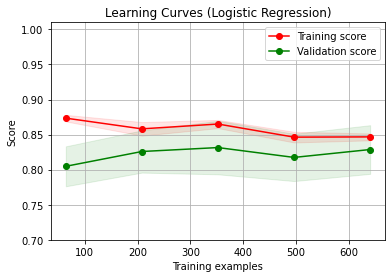

In [83]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train_poly_selected, 
                    y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

No signs of overfitting or underfitting.


3.3. Validation curve

In [ ]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train_poly_selected, y=y_train, 
                      param_name=param_name, ylim=(0.5, 1.01), param_range=param_range);

C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=C, param_range=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], groups=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Masoumeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converg

We used C=1, which is on the edge of overfitting. Regarding underfitting, there are no signs of it since the model performs well.


3.4. Submit predictions

In [86]:
# Get test data set
df = pd.read_csv('C:\\Users\\Masoumeh\\Desktop\\Data analysis and feature extraction with Python\\test.csv')
df_raw = df.copy()

In [87]:
# Transform data set (based on Chapter 2)

## 2.2
df['FamilySize'] = df['SibSp'] + df['Parch']
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)

df['Title']=0
for i in df:
    df['Title']=df_raw['Name'].str.extract('([A-Za-z]+)\.', expand=False)  
df_raw['Title'] = df['Title']  
means = df_raw.groupby('Title')['Age'].mean()
map_means = means.to_dict()
idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age, 'Age'] = df['Title'].loc[idx_nan_age].map(map_means)
df['Title'] = df['Title'].map(titles_dict)
df['Title'] = pd.Categorical(df['Title'])

df['Imputed'] = 0
df.at[idx_nan_age.values, 'Imputed'] = 1

df['Age'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])

## 2.3
passenger_id = df['PassengerId'].values
df.drop('PassengerId', axis=1, inplace=True)
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
df = pd.get_dummies(df, drop_first=1)

df = df.fillna(df.mean())  # There is one missing value in 'Fare'

X = df[df.loc[:, df.columns != 'Survived'].columns]

X_transformed = X.copy()
X_transformed['Fare'] = boxcox(X_transformed['Fare'] + 1)[0]

scaler = MinMaxScaler()
X_transformed_scaled = scaler.fit_transform(X_transformed)

poly = PolynomialFeatures(degree=2).fit(X_transformed)
X_poly = poly.transform(X_transformed_scaled)

X_poly_selected = select.transform(X_poly)

In [88]:
# Make predictions
predictions = logreg.predict(X_poly_selected)

In [89]:
# Generate submission file
submission = pd.DataFrame({ 'PassengerId': passenger_id,
                            'Survived': predictions})
submission.to_csv("submission.csv", index=False)

4. Conclusion



As Halevy et al. (2009) noted 'invariably, simple models and a lot of data trump more elaborate models based on less data.' Monica Rogati added that 'better data beats more data'. Based on these principles, the aim of this study was to improve data quality through exploratory data analysis and feature extraction. We didn't use a clever algorithm, but we explored clever techniques to make our data better.

My expectation is that after reading this kernel, you can start compiling a cookbook of techniques in exploratory data analysis and feature extraction. These techniques will help you to obtain confidence in your data and engage with any data science problem. Also, the more you use and refine these techniques, the more you'll develop your problem solving intuition.

Now, it's your turn. Make this work yours. Select a part of this kernel and play with it. Why not trying a different feature selection process? Or what about applying a different imputation method? There are a hundred different ways to steal this work like an artist. Do it... After all, all unicorns started with a MVP.
